# **Reinforcement Learning: Tarea 1, Estudio comparativo de algoritmos en un problema de k-armed bandit**

## **Autores:** Ana Gil Molina, José María García Ortiz y Levi Malest Villarreal

<br>

**Description:** En esta notebook realizaremos un experimento sobre el *problema del bandido de k brazos* con el que pretendemos comparar el desempeño de distintos algoritmos de la familia *UCB* en base a estadísticos como el porcentaje de elecciones de brazo óptimas y el *regret* acumulado en función del tiempo.

Para poder interpretar los resultados, se incluyen unas gráficas con sus respectivos análisis y conclusiones al final de la sección **[2]**.**

<br>

*This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.*

*For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html*



## **[1] - Preparación del entorno**


In [7]:
#@title Copiar el repositorio ``JMGO-coding/k_brazos_GGM``.

!git clone https://github.com/JMGO-coding/k_brazos_GGM.git
!cd k_brazos_GGM/

fatal: destination path 'k_brazos_GGM' already exists and is not an empty directory.


In [8]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_GGM')
sys.path.append('/content/k_brazos_GGM/src')

# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

from algorithms import Algorithm, UCB1, UCB2
from arms import ArmNormal, Bandit, ArmBinomial, ArmBernoulli
from plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_GGM', '/content/k_brazos_GGM/src', '/content/k_brazos_GGM', '/content/k_brazos_GGM/src']


## **[2] - Experimento**

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado. Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan varios algoritmos UCB1 y UCB2 con diferentes valores de $\alpha$. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recompensas obtenidas en esas 500 veces.

In [9]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    """
    Ejecuta experimentos comparativos entre diferentes algoritmos.

    :param bandit: Instancia de Bandit configurada para el experimento.
    :param algorithms: Lista de instancias de algoritmos a comparar.
    :param steps: Número de pasos de tiempo por ejecución.
    :param runs: Número de ejecuciones independientes.
    :return: Tuple de tres elementos: recompensas promedio, porcentaje de selecciones óptimas, y estadísticas de brazos.
    :rtype: Tuple of (np.ndarray, np.ndarray, list)
    """

    k = bandit.k
    optimal_arm = bandit.optimal_arm

    # Inicializar matrices para recompensas y selecciones óptimas
    rewards = np.zeros((len(algorithms), steps))
    optimal_selections = np.zeros((len(algorithms), steps))

    # Inicializar el regret global acumulado por cada algoritmo
    global_cumulative_regret_per_algo = np.zeros((len(algorithms),steps))

    for run in range(runs):
        # Crear una nueva instancia del bandit para cada ejecución
        current_bandit = Bandit(arms=bandit.arms)

        # Obtener la recompensa esperada óptima
        q_max = current_bandit.get_expected_value(current_bandit.optimal_arm)

        for algo in algorithms:
            algo.reset()

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        total_rewards_per_algo = np.zeros(len(algorithms))  # Para análisis por rechazo

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        # cumulative_rewards_per_algo = np.zeros(len(algorithms))

        num_choices_list = [[0 for _ in range(len(current_bandit.arms))] for _ in algorithms]   # para almacenar un conteo de las selecciones de cada brazo del bandido para cada algoritmo

        rewards_per_arm = np.zeros((len(algorithms), len(current_bandit.arms)))    # para almacenar las recompensas por cada brazo

        # Ejecutar cada algoritmo
        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()
                reward = current_bandit.pull_arm(chosen_arm)
                algo.update(chosen_arm, reward)

                num_choices_list[idx][chosen_arm] += 1   # Actualizamos el conteo del brazo seleccionado en la estapa correspondiente del algoritmo ``algo``

                rewards[idx, step] += reward
                total_rewards_per_algo[idx] += reward

                rewards_per_arm[idx][chosen_arm] += reward

                global_cumulative_regret_per_algo[idx, step] = q_max*step - total_rewards_per_algo[idx]    # Actualziamos el regret acumulado en cada paso de decisión para cada algoritmo

                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

    # Promediar las recompensas y el regret sobre todas las ejecuciones
    rewards /= runs
    optimal_selections = (optimal_selections / runs) * 100
    proportional_cumulative_regret_per_algo = global_cumulative_regret_per_algo.copy()
    proportional_cumulative_regret_per_algo /= runs
    rewards_per_arm /= runs

    return rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm

### Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan un algoritmo UCB1 y 6 algoritmos UCB2 con $\alpha = 0.1, 0.2, 0.3, 0.5, 0.7, 0.9$.

In [10]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k))    # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 1 algoritmo UCB1 y 6 algoritmos UCB2 con diferentes valores de alpha.
algorithms = [UCB1(k=k), UCB2(k=k, alpha = 0.1), UCB2(k=k, alpha = 0.2), UCB2(k=k, alpha = 0.3), UCB2(k=k, alpha = 0.5),
              UCB2(k=k, alpha = 0.7), UCB2(k=k, alpha = 0.9)]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu, "std": arm.sigma} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


### Visualización de los resultados

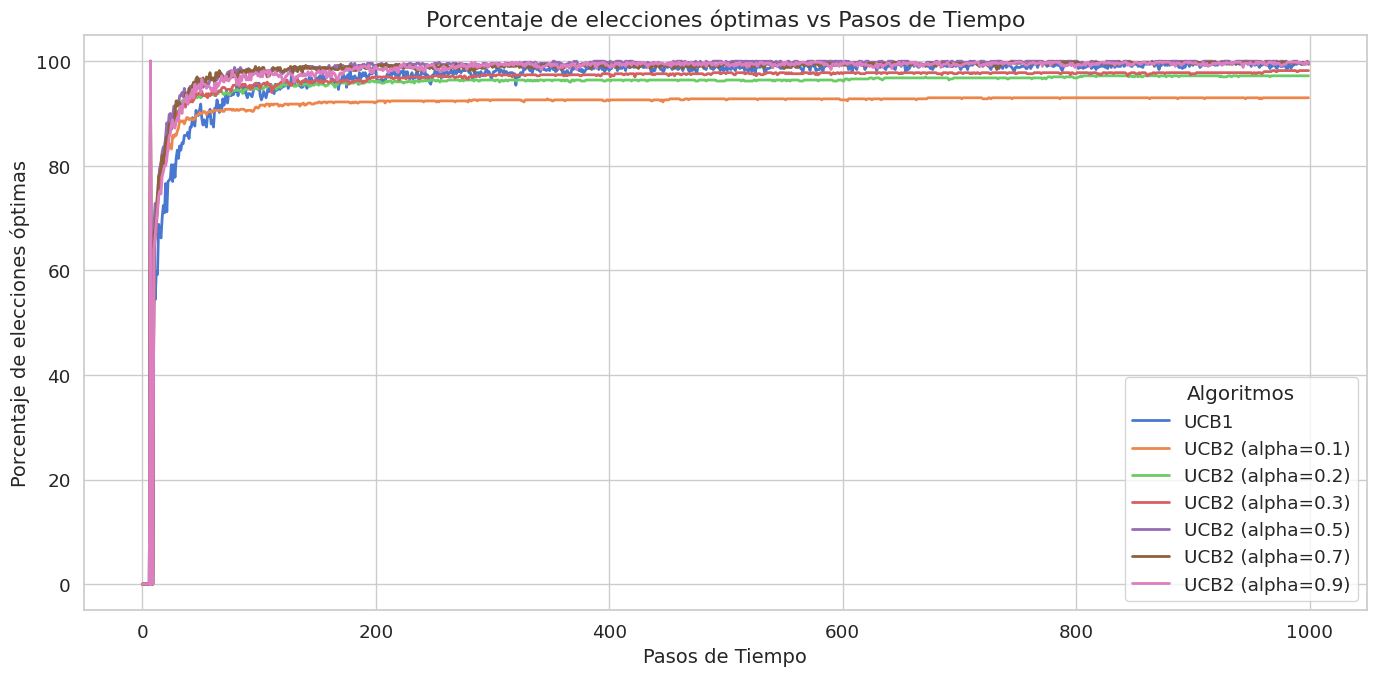

In [11]:
plot_optimal_selections(steps, optimal_selections, algorithms)

### Análisis detallado de la imagen

Esta imagen muestra un gráfico de líneas titulado **"Porcentaje de elecciones óptimas vs Pasos de Tiempo"**, donde se analiza el desempeño de las diferentes estrategias de los algoritmos UCB1 y UCB2 consideradas en un entorno de multi-armed bandit. En este caso, en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **porcentaje de elecciones óptimas** obtenido por cada algoritmo.

**Crecimiento del porcentaje de elecciones óptimas:**
  - El algoritmo UCB1 (línea **azul**) muestra un crecimiento del porcentaje de elecciones óptimas algo más lento que los demás algoritmos. Sin embargo,con el paso del tiempo, consigue alcanzar valores bastante elevados.
  - El algoritmo UCB2 con **$\alpha=0.1$** (línea **naranja**) muestra un crecimiento del porcentaje de elecciones óptimas más rápido que UCB1, pero converge en un valor inferior al de UCB1.
  - El algoritmo UCB2 con **$\alpha=0.2$** (línea **verde**) también muestra un crecimiento rápido desde el principio, y consigue alcanzar un valor mayor del porcentaje de elecciones óptimas que UCB2 con $\alpha=0.1$. Esto es debido a que valores más bajos de $\alpha$ priorizan más la explotación de forma más rápida. Sin embargo, se sigue quedando por debajo del valor alcanzado con UCB1.
  - El algoritmo UCB2 con **$\alpha=0.3$** (línea **roja**) también muestra un crecimiento rápido desde el principio, y se estabiliza en un valor mayor del porcentaje de elecciones óptimas que UCB2 con $\alpha=0.2$. Esto ocurre de nuevo porque al aumentar $\alpha$ se permite una mayor exploración mientras se sigue explotando el brazo óptimo. Sin embargo, todavía se sigue quedando por debajo del valor alcanzado con UCB1.
  - El algoritmo UCB2 con **$\alpha=0.5$** (línea **morada**) crece bastante rápido desde el principio, y consigue alcanzar un valor más elevado que los casos anteriores, consiguiendo incluso superar ligeramente a UCB1. Con este valor de $\alpha$ se consigue un balance eficiente entre exploración y explotación.
  - El algoritmo UCB2 con **$\alpha=0.7$** (línea **marrón**) muestra un rendimiento muy similar al UCB2 con $\alpha=0.5$, aunque ligeramente inferior. Podría deberse a que $\alpha = 0.7$ favorece una mayor explotación desde el principio, reduciendo más rápidamente la exploración de los brazos menos probados.
  - El algoritmo UCB2 con **$\alpha=0.9$** (línea **rosa**) también crece bastante rápido al principio, pero alcanza valores algo menores a los de los dos casos anteriores. Esto probablemente se debe a que favorece demasiado la explotación desde el principio, no explorando lo suficiente.

Esta diferencia entre el rendimiento de los algoritmos UCB1 y UCB2 podría deberse a que UCB1 utiliza una fórmula más sencilla para balancear exploración y explotación, basada en el número total de acciones $t$, y el número de veces que el brazo $a$ ha sido seleccionada $N(a)$:

$$ UCB1(a) = Q(a) + c \times \sqrt{\frac{\ln t}{N(a)}}$$

donde tomamos $c=1$. Así, UCB1 tiende a explorar más cuando un brazo ha sido seleccionado menos veces (menor $N(a)$). Además, la exploración disminuye lentamente con el tiempo porque el término $c \times \sqrt{\frac{\ln t}{N(a)}}$ disminuye más lentamente a medida que se acumulan más pasos.
  
Sin embargo, el algoritmo UCB2 mejora esta estrategia gracias a la fórmula:

$$ UCB2(a) = Q(a) + \sqrt{\frac{(1+\alpha)\ln t}{2\tau(k_a)}}$$

donde $Q(a)$ es la estimación del valor de la acción $a$, $0<\alpha<1$ es un parámetro de ajuste para el balance entre exploración y explotación, $k_a$ es el número de épocas de la acción $a$, y $\tau(k_a) = \lceil (1+\alpha)^{k_a}\rceil$ determina el número de veces que la acción a será seleccionada en un época. Gracias a $\tau(k_a)$, la exploración se vuelve más eficiente, ya que no solo depende de cuántas veces se ha seleccionado el brazo $a$, sino también de las épocas. De esta forma, la actualización de la exploración es más dinámica, pues se ajusta con el número de épocas, permitiendo que el algoritmo converja más rápido.

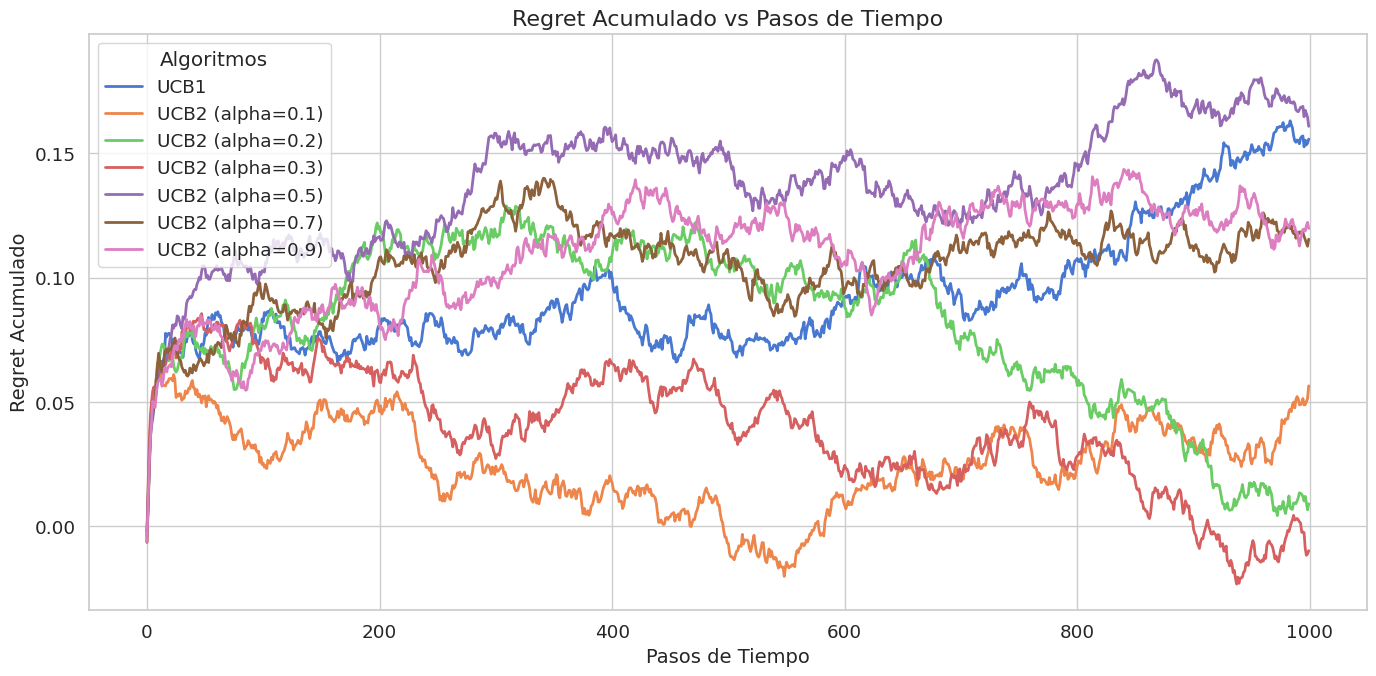

In [15]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)

### Análisis detallado de la imagen

Esta imagen muestra un gráfico de líneas titulado **"Regret acumulado vs Pasos de Tiempo"**, donde en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **regret acumulado** obtenido por cada algoritmo **UCB** considerado.

**Crecimiento del regret acumulado a lo largo del tiempo:**
  - Los algoritmos UCB1 (línea **azul**), UCB2 con **$\alpha=0.5$** (línea **morada**) muestra el peor desempeño, pues el regret crece de forma lineal con el tiempo, y con valores mucho mayores que los otros algoritmos. Esto confirma que seguir una estrategia puramente de explotación, sin nada de exploración, lleva a que el algoritmo se quede atrapado en el primer brazo escogido, que puede no ser el óptimo.
  - El algoritmo con **ε=0.01** (línea **naranja**) muestra un desempeño algo mejor. El regret aumenta al principio, pero después su crecimiento se vuelve más lento conforme el algoritmo encuentra los mejores brazos. Sin embargo, como solo explora en un 1% de los pasos, tarda demasiado en encontrar el mejor brazo.
  - El algoritmo con **ε=0.05** (línea **verde**) tiene un desempeño mejor que los casos anteriores. En los primeros pasos, el regret aumenta algo rápido, pero en poco tiempo consigue estabilizarse, siendo finalmente uno de los algoritmos con regret más bajo.
  - El algoritmo con **ε=0.1** (línea **roja**) muestra el mejor desempeño de entre todos los algoritmos estudiados. Este algoritmo consigue descubrir rápidamente el brazo óptimo, reduciendo las pérdidas por elegir opciones subóptimas.

  - El algoritmo con **ε=0.3** (línea **marrón**) también comienza con un buen desempeño, al descubrir rápidamente el brazo óptimo, pero a lo largo de tiempo, su desempeño se vuelve peor que con los anteriores algoritmos, debido a que explora demasiado después de haber encontrado el mejor brazo.
  - El algoritmo con **ε=0.4** (línea **rosa**) comienza de nuevo con un buen desempeño, con un aumento lento del regret, pero con el paso del tiempo, su desempeño se vuelve considerablemente peor que con algunos de los algoritmos anteriores, pues explora todavía más que los casos anteriores.


Según Lai y Robbins, bajo ciertas condiciones se cumple:

$$ \liminf_{T\rightarrow \infty} \frac{\sum_{i:\mu_i < \mu^*}(\mu^* - \mu_i) E[n_i]}{ln(T)} \geq \sum_{i:\mu_i < \mu^*}\frac{\mu^* - \mu_i}{I(\mu_i, \mu^*)} = Cte $$

- El numerador es $L_T$: $q^* = \mu^*$, $q(a_i)=\mu_i$, $E[n_i] = E[N_T(a_i)]$
- Consecuencia: $L_T\geq Cte\cdot \ln(T)$
- Divergencia de Kullback-Leibler: $I(\mu_i, \mu^*) = \displaystyle \int_{-\infty}^{+\infty}\log\left(\frac{p_i(x)}{p^*(x)}\right)p_j(x)\,dx$
- Con distribución normal: $I(\mu_i, \mu^*) = \frac{(\mu_i - \mu^*)^2}{2\sigma^2}$

In [13]:
def kl_normal(mu_i, mu_star, sigma_2):
    """Divergencia KL entre dos normales con la misma varianza."""
    return (mu_i - mu_star)**2 / (2 * sigma_2)

mus = [bandit.get_expected_value(num_arm) for num_arm in range(len(bandit.arms))]    # Medias de los brazos
mu_star = max(mus)   # Media del brazo óptimo
sigma_2 = 1          # Varianza de los brazos (igual para todos)

# Calcular la constante
cte = sum((mu_star - mu) / kl_normal(mu, mu_star, sigma_2) for mu in mus if mu < mu_star)

# Cota teórica
theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])

<ipython-input-13-8354763144da>:13: RuntimeWarning: divide by zero encountered in log
  theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])


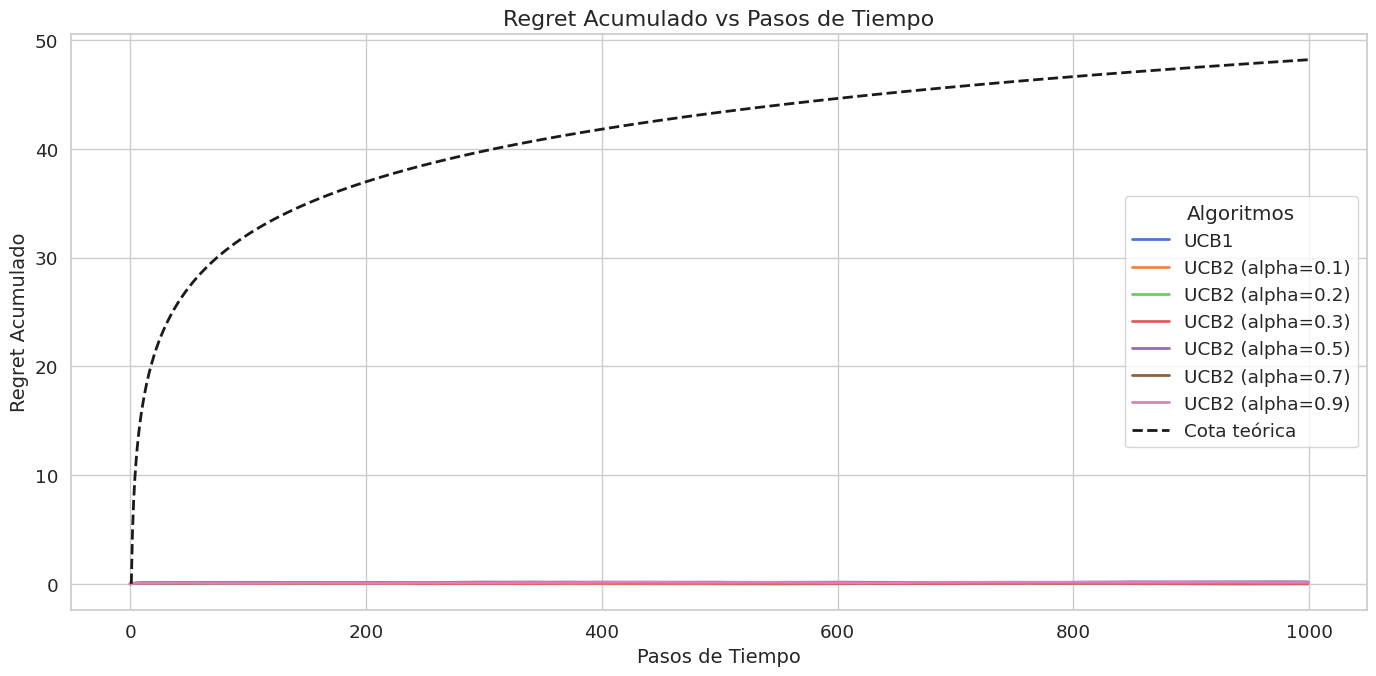

In [14]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms, theoretical_bound = theoretical_bound)